<center><img src="./images/logo_fmkn.png" width=300 style="display: inline-block;"></center> 

## Машинное обучение 2
### Семинар 8. Байесовская оптимизация

<br />
<br />
7 апреля 2022

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [6]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
from scipy.stats import norm

In [7]:
from mpl_toolkits.mplot3d import Axes3D

In [8]:
from tqdm.notebook import tqdm

### Тестовая функция

In [9]:
PI = np.pi

In [10]:
def branin_function(x):
    # x (N, 2)
    return -1.0 * (
        (x[:, 1] - 5.1 / (4 * PI**2) * x[:, 0]**2 + 5.0 / PI * x[:, 0] - 6)**2
        + 10.0 * (1.0 - 1.0 / (8 * PI)) * np.cos(x[:, 0]) + 10.0
    )

In [11]:
linear_size = 50
x1_test = np.linspace(-5, 10, linear_size)
x2_test = np.linspace(0, 15, linear_size)
xx1_test, xx2_test = np.meshgrid(x1_test, x2_test)  # (linear_size, linear_size), (linear_size, linear_size)
x_test = np.c_[xx1_test.ravel(), xx2_test.ravel()]  # (linear_size*linear_size, 2)

In [12]:
global_argmaxima = np.r_[np.c_[-np.pi, 12.275], np.c_[np.pi, 2.275], np.c_[9.42478, 2.475]]

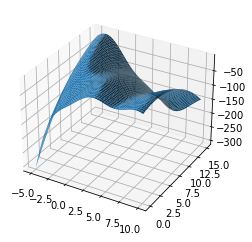

In [13]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(xx1_test, xx2_test, branin_function(x_test).reshape(linear_size, linear_size))

Text(0, 0.5, '$x_2$')

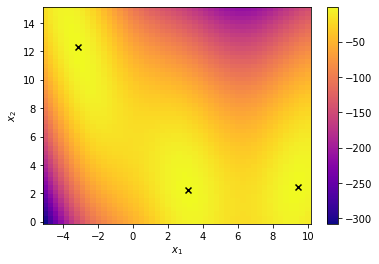

In [14]:
plt.pcolor(xx1_test, xx2_test, branin_function(x_test).reshape(linear_size, linear_size), cmap='plasma')
plt.colorbar()
plt.scatter(global_argmaxima[:, 0], global_argmaxima[:, 1], c='k', marker='x')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

Text(0, 0.5, '$x_2$')

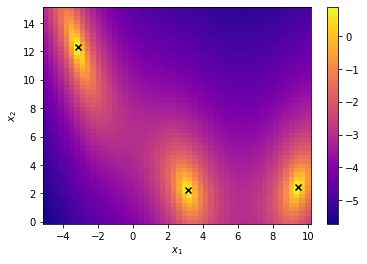

In [15]:
plt.pcolor(xx1_test, xx2_test, -np.log(-branin_function(x_test)).reshape(linear_size, linear_size), cmap='plasma')
plt.colorbar()
plt.scatter(global_argmaxima[:, 0], global_argmaxima[:, 1], c='k', marker='x')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')

In [16]:
global_maxima = branin_function(global_argmaxima)

In [17]:
global_maxima

array([-0.39788736, -0.39788736, -0.39788736])

### Aquistion functions

In [18]:
def expected_improvement(y_best, gp):
    
    standard_normal = norm
    
    def wrap(x):
        mean, std = gp.predict(x.reshape(-1, 2), return_std=True)
        ei = (
            (mean.ravel() - y_best) * standard_normal.cdf((mean.ravel() - y_best) / std) 
            + std * norm.pdf((-(mean.ravel() - y_best) / std))
        )
        return ei
    
    return wrap

# Warmup

In [19]:
np.random.seed(1234)

In [20]:
X = np.random.rand(12, 2) * (np.c_[15.0, 15.0] - np.c_[5.0, 0.0])
Y = branin_function(X)

(0.0, 10.0)

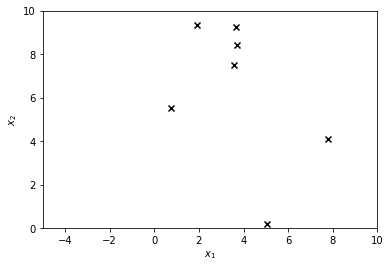

In [21]:
plt.scatter(X[:, 0], X[:, 1], c='k', marker='x')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.xlim(-5, 10)
plt.ylim(0, 10)

### GP

In [22]:
kernel = Matern(nu=5.0/2.0)
model = GaussianProcessRegressor(kernel, random_state=1234)

In [23]:
def train_gp(model, train_X, train_Y):
    
    data_mean = train_Y.mean(axis=0)  # (2,)
    data_std = train_Y.std(axis=0)  # (2,)
    Y = (train_Y - data_mean) / data_std
    
    model.fit(train_X, Y)
    
    return model, data_mean, data_std

In [24]:
model, data_mean, data_std = train_gp(model, X, Y)

### Inspect acquisition

In [25]:
y_best = np.max((Y - data_mean) / data_std) + 0.0

acq = expected_improvement(y_best, model)(x_test)

In [26]:
def plot_acquistion(ax, acq, X):
    im = ax.pcolor(x1_test, x2_test, acq.reshape(linear_size, linear_size), cmap='viridis')
    fig.colorbar(im, ax=ax)
    ax.scatter(X[:, 0], X[:, 1], c='k', marker='x')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

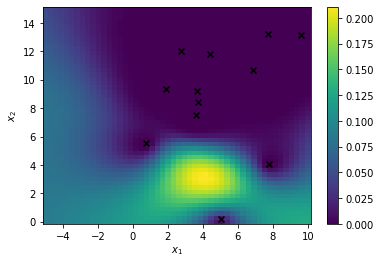

In [27]:
ax = plt.gca()
plot_acquistion(ax, acq, X)

### Other acqusition functions

In [28]:
def gp_ucb(gp, beta=0.3):
    def wrap(x):
        # ucb(x) = mean(x) + beta * std(x)
        raise NotImplementedError("Implement it yourself")
    return wrap

In [29]:
def probability_of_improvement(y_best, gp):
    def wrap(x):
        # POI(x) = Phi((mean(x) - y_best) / std(x))
        raise NotImplementedError("Implement it yourself")
    return wrap

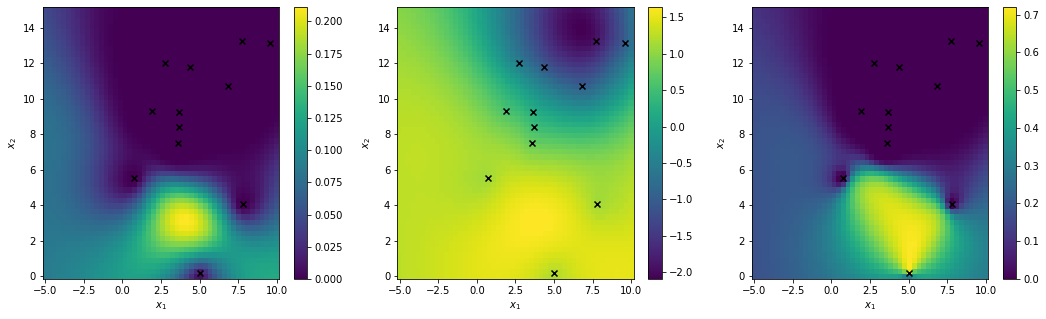

In [26]:
y_best = np.max((Y - data_mean) / data_std) + 0.0

fig = plt.figure(figsize=(3*6, 5))
gs = gridspec.GridSpec(nrows=1, ncols=3)

acq_functions = [expected_improvement(y_best, model), gp_ucb(model, beta=1.0), probability_of_improvement(y_best, model)]
for i, acq_function in enumerate(acq_functions):
    ax = fig.add_subplot(gs[i])
    acq = acq_function(x_test)
    plot_acquistion(ax, acq, X)

### Optimize acqusition

In [30]:
from scipy.optimize import minimize

In [31]:
def optimize_acqusition(model, acq_function, bounds, n_restarts=5):
    fun = lambda x: -acq_function(x.reshape(-1, 2)).ravel()
    cands = []
    vals = []
    for i in range(n_restarts):
        x_init = np.random.rand(1, 2) * (
            np.c_[bounds[0][1] - bounds[0][0], bounds[1][1] - bounds[1][0]] + np.c_[bounds[0][0], bounds[1][0]]
        )
        res = minimize(fun, x_init, method='L-BFGS-B', bounds=bounds)
        cands.append(res.x)
        vals.append(-res.fun)
        
    best_cand = np.argmax(vals)
    return cands[best_cand]

In [32]:
bounds = ((-5, 10), (0, 15))

In [36]:
new_x = optimize_acqusition(model, expected_improvement(y_best, model), bounds, n_restarts=10)

In [37]:
new_x

array([4.08539968, 3.12524701])

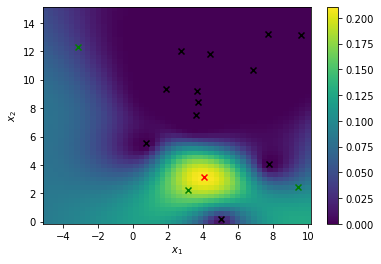

In [38]:
ax = plt.gca()

plot_acquistion(ax, expected_improvement(y_best, model)(x_test), X)
ax.scatter(new_x[0], new_x[1], c='r', marker='x')
ax.scatter(global_argmaxima[:, 0], global_argmaxima[:, 1], c='g', marker='x')

In [33]:
from tensorboardX import SummaryWriter
writer = SummaryWriter(log_dir='./bayesopt_runs/')

In [35]:
def gp_ucb_callback(model, X, Y):
    return gp_ucb(model)

In [36]:
def callback(model, acq_function, X, Y, new_x, y_cand, step):
    writer.add_scalar('Branin/evaluation', y_cand, step)
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    plot_acquistion(ax, acq_function(x_test), X)
    ax.scatter(new_x[:, 0], new_x[:, 1], c='r', marker='x')
    ax.scatter(global_argmaxima[:, 0], global_argmaxima[:, 1], c='g', marker='x')
    
    writer.add_figure('Branin/acq', fig, step)

In [34]:
def bayesian_optimize(objective, warmup_X, warmup_Y, acq_function_callback, bounds, n_iter=10, callback=None):
    """
    acq_function_callback(model, X, Y) - create an acquistion function
    callback(model, acq_function, X, Y, new_x, new_y, step) - call summary writer
    """
    
    X = warmup_X
    Y = warmup_Y
    
    iterator = tqdm(range(n_iter))
    for i in iterator:
        # fit a gp
        kernel = Matern(nu=5.0/2.0)
        model = GaussianProcessRegressor(kernel, random_state=1234)
        ...
        
        # optimize acq
        # don't forget to scale Y according to its mean and standard deviation
        acq_function = acq_function_callback(model, X, (Y - data_mean) / data_std)
        new_x = ...
        
        # compute objective
        y_cand = objective(new_x)
        
        # call callback 
        ...
        
        # update dataset
        X = np.r_[X, new_x].reshape(-1, 2)
        Y = np.r_[Y.reshape(-1), y_cand.reshape(-1)].reshape(-1, 1)
        
    y_best = np.argmax(Y)
    x_best = X[y_best]
    
    return x_best, y_best, (X, Y)

In [37]:
x_best, y_best, dataset = bayesian_optimize(branin_function, X, Y, gp_ucb_callback, bounds, n_iter=10, callback=callback)

  0%|          | 0/10 [00:00<?, ?it/s]

In [38]:
writer.close()

In [39]:
dataset[1][y_best],  global_maxima

(array([-0.39919259]), array([-0.39788736, -0.39788736, -0.39788736]))

### Try different acqusitions

In [39]:
def ei_callback(model, X, Y):
    y_best = np.max(Y)
    return expected_improvement(y_best, model)

In [41]:
def callback(model, acq_function, X, Y, new_x, y_cand, step):
    writer.add_scalar('Branin-EI/evaluation', y_cand, step)
    
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111)
    plot_acquistion(ax, acq_function(x_test), X)
    ax.scatter(new_x[:, 0], new_x[:, 1], c='r', marker='x')
    ax.scatter(global_argmaxima[:, 0], global_argmaxima[:, 1], c='g', marker='x')
    
    writer.add_figure('Branin-EI/acq', fig, step)

In [42]:
x_best, y_best, dataset = bayesian_optimize(branin_function, X, Y, ei_callback, bounds, n_iter=10, callback=callback)

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
dataset[1][y_best],  global_maxima

(array([-0.74904301]), array([-0.39788736, -0.39788736, -0.39788736]))

### Maybe a better optimization strategy of EI will help with EI?

In [46]:
# Check it out! E.g. more restarts for minimize, etc

### (Almost) real-world example

In [40]:
# !pip install ax-platform

In [62]:
import torch
import torch.nn.functional as F
import ax

In [63]:
import torchvision

In [64]:
# Use standard FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)

In [151]:
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])

In [65]:
# Use standard FashionMNIST dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()                                 
    ])
)

In [99]:
class Network(torch.nn.Module):
    @property
    def device(self):
        return next(self.parameters()).device
    
    def __init__(self):
        super().__init__()

        # define layers
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = torch.nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = torch.nn.Linear(in_features=120, out_features=60)
        self.out = torch.nn.Linear(in_features=60, out_features=10)

    # define forward function
    def forward(self, t):
        # conv 1
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # conv 2
        t = self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        # fc1
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)

        # fc2
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)
        return t

In [100]:
params = dict(
    lr = 0.1,
    momentum = 0.9,
    batch_size = 64,
)
epochs = 10

In [135]:
def train_on_batch(model, x_batch, y_batch, optimizer, loss_function):
    model.train()
    optimizer.zero_grad()
    
    output = model(x_batch.to(model.device))

    
    loss = loss_function(output, y_batch.to(model.device))
    loss.backward()

    optimizer.step()
    return loss.cpu().item()

In [136]:
def train_epoch(train_generator, model, loss_function, optimizer, callback=None):
    epoch_loss = 0
    total = 0
    for it, (batch_of_x, batch_of_y) in enumerate(train_generator):
        batch_loss = train_on_batch(model, batch_of_x, batch_of_y, optimizer, loss_function)
        
        if callback is not None:
            with torch.no_grad():
                callback(model, batch_loss)
            
        epoch_loss += batch_loss*len(batch_of_x)
        total += len(batch_of_x)
    
    return epoch_loss/total

In [137]:
def trainer(count_of_epoch, 
            batch_size, 
            dataset,
            model, 
            loss_function,
            lr = 0.001,
            momentum = 0.9,
            callback = None):

    optima = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
    
    iterations = tqdm(range(count_of_epoch), desc='epoch')
    iterations.set_postfix({'train epoch loss': np.nan})
    for it in iterations:
        batch_generator = tqdm(
            torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False), 
            leave=False, total=len(dataset)//batch_size+(len(dataset)%batch_size> 0))
        
        epoch_loss = train_epoch(train_generator=batch_generator, 
                    model=model, 
                    loss_function=loss_function, 
                    optimizer=optima, 
                    callback=callback)
        
        iterations.set_postfix({'train epoch loss': epoch_loss})

In [138]:
loss_function = torch.nn.CrossEntropyLoss()

In [173]:
def train_and_validate(parameters):
    model = Network()
    trainer(
        epochs,
        batch_size=params['batch_size'],
        dataset=train_dataset,
        model=model,
        loss_function=loss_function,
        lr=params['lr'],
        momentum=params['momentum']
    )
    
    test_dl = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=64, shuffle=False)
    total = 0 
    acc = 0
    for i, (x_batch, y_batch) in enumerate(test_dl):
        y_pred = torch.argmax(model(x_batch.to(model.device)), dim=-1)
        
        acc += (y_pred == y_batch).sum()        
        total += len(x_batch)
        
    return (acc / total).item()
        

In [169]:
acc = train_and_validate(params)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

In [174]:
acc.item()

0.8222000002861023

In [175]:
parameters = [
    {'name': 'lr', 'type': 'range', 'bounds': [0.001, 0.1]},
    {'name': 'momentum', 'type': 'range', 'bounds': [0.5, 0.9]},
    {'name': 'batch_size', 'type': 'choice', 'values': [32, 64, 128, 256, 512]}
]

In [183]:
epochs = 10

In [184]:
best_parameters, best_values, experiment, gp_model = ax.optimize(
    parameters=parameters,
    evaluation_function=train_and_validate,
    minimize=False,
)

[INFO 04-06 15:37:11] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-06 15:37:11] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-06 15:37:11] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batch_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
/home/peter/workplace/tb_venv/lib/python3.8/site-packages/ax/core/parameter.py:467: UserWarning:

`is_ordered` is not specified for `ChoiceParameter` "batch_size". Defaulting to `True` for parameters of `ParameterType` INT. To override this behavi

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:38:22] ax.service.managed_loop: Running optimization trial 2...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:39:33] ax.service.managed_loop: Running optimization trial 3...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:40:47] ax.service.managed_loop: Running optimization trial 4...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:42:02] ax.service.managed_loop: Running optimization trial 5...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:43:49] ax.service.managed_loop: Running optimization trial 6...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:45:02] ax.service.managed_loop: Running optimization trial 7...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:46:15] ax.service.managed_loop: Running optimization trial 8...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:47:27] ax.service.managed_loop: Running optimization trial 9...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:48:40] ax.service.managed_loop: Running optimization trial 10...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:49:53] ax.service.managed_loop: Running optimization trial 11...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:51:04] ax.service.managed_loop: Running optimization trial 12...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:52:15] ax.service.managed_loop: Running optimization trial 13...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:53:26] ax.service.managed_loop: Running optimization trial 14...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:54:39] ax.service.managed_loop: Running optimization trial 15...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:55:51] ax.service.managed_loop: Running optimization trial 16...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:57:16] ax.service.managed_loop: Running optimization trial 17...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:58:28] ax.service.managed_loop: Running optimization trial 18...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 15:59:40] ax.service.managed_loop: Running optimization trial 19...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[INFO 04-06 16:00:53] ax.service.managed_loop: Running optimization trial 20...


epoch:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

[WARNING 04-06 16:02:08] ax.modelbridge.cross_validation: Metric objective was unable to be reliably fit.
[WARNING 04-06 16:02:08] ax.service.utils.best_point: Model fit is poor; falling back on raw data for best point.
[WARNING 04-06 16:02:08] ax.service.utils.best_point: Model fit is poor and data on objective metric objective is noisy; interpret best points results carefully.


In [186]:
best_parameters, best_values[0]

({'lr': 0.07540824335813523, 'momentum': 0.823064637184143, 'batch_size': 512},
 {'objective': 0.8657000064849854})

In [192]:
objective_means = np.array([[trial.objective_mean for trial in experiment.trials.values()]]).ravel()

In [ ]:
plt.plot(np.arange(len(objective_means)), objective_means)

### Ways to improve
- Try other acquistion functions. Default = EI
- Try other parameter bounds
- Try a different NN architecture :)

Non-default acquisition function and generation strategy:

In [ ]:
from ax.modelbridge.registry import Models
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from botorch.acquisition import UpperConfidenceBound
from ax.modelbridge.modelbridge_utils import get_pending_observation_features
from ax.models.torch.botorch_modular.surrogate import Surrogate
from botorch.models.gp_regression import SingleTaskGP

gs = GenerationStrategy(
    steps=[
        GenerationStep(  # Initialization step
            # Which model to use for this step
            model=Models.SOBOL,
            # How many generator runs (each of which is then made a trial) 
            # to produce with this step
            num_trials=5,
            # How many trials generated from this step must be `COMPLETED` 
            # before the next one
            min_trials_observed=5, 
        ),
        GenerationStep(  # BayesOpt step
            model=Models.BOTORCH_MODULAR,
            # No limit on how many generator runs will be produced
            num_trials=-1,
            model_kwargs={  # Kwargs to pass to `BoTorchModel.__init__`
                "surrogate": Surrogate(SingleTaskGP),
                "botorch_acqf_class": UpperConfidenceBound,
            },
        )
    ]
)

In [ ]:
best_parameters, best_values, experiment, gp_model = ax.optimize(
    parameters=parameters,
    evaluation_function=train_and_validate,
    minimize=False,
    generation_strategy=gs
)